#1) Implement a basic autoencoder and train it on a dataset like MNIST for image reconstruction.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Load and preprocess MNIST
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train[..., np.newaxis] / 255.0
x_test = x_test[..., np.newaxis] / 255.0

# Autoencoder architecture
inp = layers.Input((28,28,1))
x = layers.Conv2D(32,3,activation='relu',padding='same')(inp)
x = layers.MaxPooling2D(2,padding='same')(x)
x = layers.Conv2D(16,3,activation='relu',padding='same')(x)
x = layers.MaxPooling2D(2,padding='same')(x)
x = layers.Conv2D(16,3,activation='relu',padding='same')(x)
x = layers.UpSampling2D(2)(x)
x = layers.Conv2D(32,3,activation='relu',padding='same')(x)
x = layers.UpSampling2D(2)(x)
out = layers.Conv2D(1,3,activation='sigmoid',padding='same')(x)

autoencoder = models.Model(inp, out)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Train
autoencoder.fit(x_train, x_train, epochs=30, batch_size=128, validation_data=(x_test, x_test), verbose=1)

# Visualize
decoded = autoencoder.predict(x_test)
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    ax.set_title('Original')
    ax.axis('off')
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(decoded[i].squeeze(), cmap='gray')
    ax.set_title('Reconstructed')
    ax.axis('off')
plt.show()


# 2) Explore different regularization techniques such as L1/L2 regularization or dropout and compare their effects on the autoencoder's performance.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Load and preprocess data
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

def build_autoencoder(reg_type=None, reg_rate=0.0, dropout_rate=0.0):
    input_img = layers.Input((28, 28, 1))

    if reg_type == 'l1':
        regularizer = regularizers.l1(reg_rate)
    elif reg_type == 'l2':
        regularizer = regularizers.l2(reg_rate)
    elif reg_type == 'l1_l2':
        regularizer = regularizers.l1_l2(l1=reg_rate, l2=reg_rate)
    else:
        regularizer = None

    x = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizer)(input_img)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    x = layers.MaxPooling2D(2, padding='same')(x)

    x = layers.Conv2D(16, 3, activation='relu', padding='same', kernel_regularizer=regularizer)(x)
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    encoded = layers.MaxPooling2D(2, padding='same')(x)

    x = layers.Conv2D(16, 3, activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D(2)(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.UpSampling2D(2)(x)
    decoded = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)

    return models.Model(input_img, decoded)

def train_autoencoder(config):
    model = build_autoencoder(config['reg_type'], config['reg_rate'], config['dropout_rate'])
    model.compile(optimizer=tf.keras.optimizers.Adam(config['lr']), loss='binary_crossentropy')

    callbacks_list = []
    if config['early_stop']:
        callbacks_list.append(callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True))

    if config['data_aug']:
        datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.1)
        train_gen = datagen.flow(x_train, x_train, batch_size=128)
        history = model.fit(train_gen, steps_per_epoch=len(x_train)//128, epochs=2, validation_data=(x_test, x_test), callbacks=callbacks_list, verbose=0)
    else:
        history = model.fit(x_train, x_train, epochs=10, batch_size=128, validation_data=(x_test, x_test), callbacks=callbacks_list, verbose=0)

    return round(history.history['loss'][-1], 4), round(history.history['val_loss'][-1], 4)

# Experiment configurations
experiments = [
    {'reg_type': None, 'reg_rate': 0.0, 'dropout_rate': 0.0, 'lr': 0.001, 'early_stop': False, 'data_aug': False},
    {'reg_type': 'l1', 'reg_rate': 0.001, 'dropout_rate': 0.0, 'lr': 0.001, 'early_stop': False, 'data_aug': False},
    {'reg_type': 'l2', 'reg_rate': 0.001, 'dropout_rate': 0.0, 'lr': 0.001, 'early_stop': False, 'data_aug': False},
    {'reg_type': 'l1_l2', 'reg_rate': 0.001, 'dropout_rate': 0.0, 'lr': 0.001, 'early_stop': False, 'data_aug': False},
    {'reg_type': None, 'reg_rate': 0.0, 'dropout_rate': 0.3, 'lr': 0.001, 'early_stop': False, 'data_aug': False},
    {'reg_type': None, 'reg_rate': 0.0, 'dropout_rate': 0.0, 'lr': 0.001, 'early_stop': True, 'data_aug': False},
    {'reg_type': None, 'reg_rate': 0.0, 'dropout_rate': 0.0, 'lr': 0.001, 'early_stop': False, 'data_aug': True},
]

# Run experiments
results = []
for i, config in enumerate(experiments, 1):
    print(f"Experiment {i}: {config}")
    train_loss, val_loss = train_autoencoder(config)

    if config['reg_type']:
        reg_desc = config['reg_type'].upper()
    elif config['dropout_rate'] > 0:
        reg_desc = "Dropout"
    elif config['early_stop']:
        reg_desc = "Early Stopping"
    elif config['data_aug']:
        reg_desc = "Data Augmentation"
    else:
        reg_desc = "None"

    results.append({
        'S.no': i,
        'Regularization': reg_desc,
        'Dropout_rate': config['dropout_rate'],
        'Regularization_rate': config['reg_rate'],
        'Learning_rate': config['lr'],
        'Training_loss': train_loss,
        'Validation_loss': val_loss
    })

# Display results
print("\nResults:")
for r in results:
    print(f"{r['S.no']:2d} | {r['Regularization']:15s} | Dropout: {r['Dropout_rate']:<4} | Reg Rate: {r['Regularization_rate']:<6} | LR: {r['Learning_rate']:<6} | Train Loss: {r['Training_loss']:<6} | Val Loss: {r['Validation_loss']:<6}")


# 3) Implement a variational autoencoder (VAE) and train it on a dataset like MNIST to generate new images.

In [ ]:
import numpy as np, tensorflow as tf, keras
from keras import layers, ops

class Sampling(layers.Layer):
    def __init__(self, **kw):
        super().__init__(**kw)
        self.seed = keras.random.SeedGenerator(1337)  # Create once here
    def call(self, inputs):
        m, s = inputs
        eps = keras.random.normal(ops.shape(m), seed=self.seed)
        return m + s * eps

# Encoder
latent_dim = 2
e_in = keras.Input((28,28,1))
x = layers.Conv2D(32,3,2,"same",activation="relu")(e_in)
x = layers.Conv2D(64,3,2,"same",activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(16,activation="relu")(x)
m = layers.Dense(latent_dim)(x)
s = layers.Dense(latent_dim,activation="softplus")(x)
z = Sampling()([m,s])
encoder = keras.Model(e_in, [m, s, z])

# Decoder
d_in = keras.Input((latent_dim,))
x = layers.Dense(7*7*64,activation="relu")(d_in)
x = layers.Reshape((7,7,64))(x)
x = layers.Conv2DTranspose(64,3,2,"same",activation="relu")(x)
x = layers.Conv2DTranspose(32,3,2,"same",activation="relu")(x)
d_out = layers.Conv2DTranspose(1,3,1,"same",activation="sigmoid")(x)
decoder = keras.Model(d_in, d_out)

# VAE
class VAE(keras.Model):
    def __init__(self, enc, dec, **kw):
        super().__init__(**kw)
        self.enc, self.dec = enc, dec
    def train_step(self, data):
        with tf.GradientTape() as tape:
            m, s, z = self.enc(data)
            r = self.dec(z)
            rl = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, r), axis=(1,2)))
            kl = tf.reduce_mean(tf.reduce_sum(0.5*(s**2+m**2 - 2*tf.math.log(s+1e-8)-1), axis=1))
            loss = rl + kl
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": loss}

# Data
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
data = np.expand_dims(np.concatenate([x_train, x_test])/255.0, -1)

# Train
vae = VAE(encoder, decoder)
vae.compile(optimizer="adam")
vae.fit(data, epochs=30, batch_size=128)

In [ ]:
# Generate Variations
idx = int(input("Enter index: "))
if not 0 <= idx < len(data): raise ValueError("Index out of range")
img = data[idx:idx+1]
plt.imshow(img[0].squeeze(), cmap="gray"); plt.axis("off"); plt.show()
m, s, _ = encoder.predict(img)
noise = np.random.normal(size=(10, latent_dim))
z_vars = m + s * noise
gen = decoder.predict(z_vars)
plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(gen[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.show()

# 4) Implement a basic autoregressive model like the Fully Visible Sigmoid Belief Network (FVSBN) and train it on a dataset like MNIST.

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

class FVSBNLayer(tf.keras.layers.Layer):
    """Custom layer for FVSBN autoregressive computation."""
    def __init__(self, dim):
        super(FVSBNLayer, self).__init__()
        self.dim = dim
        self.mask = tf.constant(np.tril(np.ones((dim, dim)), k=-1), dtype=tf.float32)

    def build(self, input_shape):
        self.kernel = self.add_weight(name="kernel", shape=(self.dim, self.dim), initializer="random_normal")
        self.bias = self.add_weight(name="bias", shape=(self.dim,), initializer="zeros")

    def call(self, inputs):
        masked_kernel = self.kernel * self.mask
        logits = tf.matmul(inputs, masked_kernel, transpose_b=True) + self.bias
        return logits

class FVSBN(tf.keras.Model):
    """FVSBN model for binary data."""
    def __init__(self, dim):
        super(FVSBN, self).__init__()
        self.dim = dim
        self.layer = FVSBNLayer(dim)

    def call(self, inputs):
        logits = self.layer(inputs)
        return tf.nn.sigmoid(logits)

    def compute_loss(self, inputs):
        logits = self.layer(inputs)
        return tf.keras.losses.BinaryCrossentropy(from_logits=True)(inputs, logits)

    def sample(self, num_samples):
        samples = tf.zeros((num_samples, self.dim), dtype=tf.float32)
        for i in range(self.dim):
            probs = self(samples)[:, i]
            samples_i = tfp.distributions.Bernoulli(probs=probs).sample()
            samples = tf.tensor_scatter_nd_update(samples, [[j, i] for j in range(num_samples)], tf.cast(samples_i, tf.float32))
        return samples

def load_mnist_data():
    """Load and binarize MNIST data."""
    (x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
    x_train = (x_train / 255.0) > 0.5  # Binarize
    x_test = (x_test / 255.0) > 0.5
    x_train = x_train.reshape(-1, 784).astype(np.float32)
    x_test = x_test.reshape(-1, 784).astype(np.float32)
    return x_train[:10000], x_test[:1000]  # Subset for faster training

def train_fvsbn(model, data, epochs=200, batch_size=128, learning_rate=0.001):
    """Train the FVSBN model."""
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(10000).batch(batch_size)
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataset:
            with tf.GradientTape() as tape:
                loss = model.compute_loss(batch)
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            total_loss += loss.numpy()
        if (epoch + 1) % 2 == 0:
            print(f"Epoch {epoch + 1}, Loss: {total_loss / len(dataset):.4f}")

def visualize_samples(samples, title="Generated MNIST Samples"):
    """Visualize generated samples as 28x28 images."""
    samples = samples.numpy().reshape(-1, 28, 28)
    plt.figure(figsize=(10, 2))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(samples[i], cmap="binary")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

if __name__ == "__main__":
    # Set random seed for reproducibility
    tf.random.set_seed(42)
    np.random.seed(42)

    # Load data
    dim = 28 * 28  # MNIST image size
    x_train, x_test = load_mnist_data()

    # Initialize and train model
    model = FVSBN(dim=dim)
    train_fvsbn(model, x_train)

    # Evaluate on a test sample
    test_sample = x_test[:1]
    log_prob = -model.compute_loss(test_sample) * dim
    print(f"Log probability of test image: {log_prob.numpy():.4f}")

    # Generate and visualize samples
    samples = model.sample(5)
    visualize_samples(samples)

# 5) Implement NADE and train it on a dataset like MNIST for image generation.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Force float32 globally
tf.keras.mixed_precision.set_global_policy('float32')
tf.config.optimizer.set_jit(False)

# --------------------------- Data Loader ---------------------------
def load_binarized_mnist(train_size=5000, test_size=500):
    (x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
    x_train = (x_train / 255.0).reshape(-1, 28*28)
    x_test = (x_test / 255.0).reshape(-1, 28*28)
    x_train = (x_train > 0.5).astype(np.float32)[:train_size]
    x_test = (x_test > 0.5).astype(np.float32)[:test_size]
    return x_train, x_test

# --------------------------- NADE Model ---------------------------
class NADE(tf.keras.Model):
    def __init__(self, D, H):
        super().__init__()
        self.D, self.H = D, H
        self.W = self.add_weight(name="W", shape=(H, D), initializer="glorot_uniform")
        self.V = self.add_weight(name="V", shape=(H, D), initializer="glorot_uniform")
        self.c = self.add_weight(name="c", shape=(H,), initializer="zeros")
        self.b = self.add_weight(name="b", shape=(D,), initializer="zeros")

    @tf.function
    def call(self, x):
        batch_size = tf.shape(x)[0]
        a = tf.tile(self.c[None, :], [batch_size, 1])
        outputs = tf.TensorArray(dtype=tf.float32, size=self.D)

        for i in tf.range(self.D):
            h = tf.nn.sigmoid(a)
            logit = tf.einsum('bh,h->b', h, self.V[:, i]) + self.b[i]
            prob = tf.nn.sigmoid(logit)[:, None]
            outputs = outputs.write(i, prob)
            a = a + x[:, i:i+1] @ tf.transpose(self.W[:, i:i+1])

        return tf.transpose(outputs.stack(), [1, 0, 2])[:, :, 0]

    @tf.function
    def compute_loss(self, x):
        probs = self(x)
        return tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, probs))

# --------------------------- Training ---------------------------
def train_model(model, x_train, epochs=30, batch_size=256, lr=2e-3, visualize_every=5):
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    for epoch in range(epochs):
        losses = []
        for step, batch in enumerate(dataset):
            with tf.GradientTape() as tape:
                loss = model.compute_loss(batch)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            losses.append(loss.numpy())

        print(f"Epoch {epoch+1}/{epochs} | Loss: {np.mean(losses):.4f}")

        # Optional visualization every few epochs
        if (epoch+1) % visualize_every == 0:
            visualize_samples(model)

def visualize_samples(model, num_samples=16):
    samples = model_sample(model, num_samples)
    plt.figure(figsize=(4, 4))
    for i in range(num_samples):
        plt.subplot(4, 4, i+1)
        plt.imshow(samples[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()

def model_sample(model, num_samples=16):
    D = model.D
    x = tf.zeros((num_samples, D), dtype=tf.float32)
    a = tf.tile(model.c[None, :], [num_samples, 1])

    for i in range(D):
        h = tf.nn.sigmoid(a)
        logit = tf.einsum('bh,h->b', h, model.V[:, i]) + model.b[i]
        prob = tf.nn.sigmoid(logit)
        xi = tf.cast(tf.random.uniform((num_samples,)) < prob, tf.float32)
        x = tf.concat([x[:, :i], xi[:, None], x[:, i+1:]], axis=1) # Corrected line
        a = a + xi[:, None] @ tf.transpose(model.W[:, i:i+1])
    return x.numpy()

# --------------------------- Main ---------------------------
x_train, x_test = load_binarized_mnist()
D = x_train.shape[1]

print("\nTraining NADE (Optimized)...")
nade = NADE(D=D, H=256)
train_model(nade, x_train, epochs=50, batch_size=256, lr=2e-3, visualize_every=5)

print("Final Sampling...")
visualize_samples(nade)

# 6) Implement MADE and train it on a dataset like MNIST for image generation.

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

# ---------------- Data ----------------
def load_binarized_mnist(train_size=5000, test_size=500):
    (x_train, _), _ = tf.keras.datasets.mnist.load_data()
    x_train = ((x_train/255.0) > 0.5).astype(np.float32).reshape(-1, 28*28)
    return x_train[:train_size]

def visualize_samples(samples, title="Samples"):
    samples = samples.reshape(-1,28,28)
    plt.figure(figsize=(10,2))
    for i in range(min(8,samples.shape[0])):
        plt.subplot(1,min(8,samples.shape[0]),i+1)
        plt.imshow(samples[i],cmap="binary"); plt.axis("off")
    plt.suptitle(title); plt.show()

# ---------------- MADE ----------------
class MADE(tf.keras.Model):
    def __init__(self, D, H, seed=None):
        super().__init__()
        self.D, self.H = D,H
        rng = np.random.RandomState(seed)
        self.deg_input = np.arange(1,D+1)
        self.deg_hidden = rng.randint(1,D,size=H)
        self.deg_output = np.arange(1,D+1)

        self.W_in_hid = self.add_weight(name="W_in_hid", shape=(D,H),
                                        initializer="glorot_uniform")
        self.b_hid = self.add_weight(name="b_hid", shape=(H,), initializer="zeros")
        self.W_hid_out = self.add_weight(name="W_hid_out", shape=(H,D),
                                         initializer="glorot_uniform")
        self.b_out = self.add_weight(name="b_out", shape=(D,), initializer="zeros")

        self.mask_in_hid = (self.deg_input[:,None]<=self.deg_hidden[None,:]).astype(np.float32)
        self.mask_hid_out = (self.deg_hidden[:,None]<self.deg_output[None,:]).astype(np.float32)

    def call(self,x):
        h = tf.nn.relu(tf.matmul(x,self.W_in_hid*self.mask_in_hid)+self.b_hid)
        out = tf.matmul(h,self.W_hid_out*self.mask_hid_out)+self.b_out
        return tf.nn.sigmoid(out)

    def compute_loss(self,x):
        return tf.reduce_mean(tf.keras.losses.binary_crossentropy(x,self(x)))

    def sample(self,n):
        x = np.zeros((n,self.D),np.float32)
        for i in range(self.D):
            probs = self(x)[:,i]
            x[:,i] = tfp.distributions.Bernoulli(probs=probs).sample().numpy()
        return x

# ---------------- Training ----------------
def train_model(model,x_train,epochs=3,batch_size=128,lr=1e-3):
    opt = tf.keras.optimizers.Adam(lr)
    ds = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(batch_size)
    for e in range(epochs):
        loss = np.mean([model.compute_loss(batch).numpy() for batch in ds])
        print(f"Epoch {e+1}/{epochs} - loss: {loss:.4f}")

# ---------------- Main ----------------
if __name__=="__main__":
    tf.random.set_seed(0); np.random.seed(0)
    x_train = load_binarized_mnist(train_size=2000)
    made = MADE(D=28*28,H=400,seed=2)
    train_model(made,x_train,epochs=2000,batch_size=128,lr=1e-3)
    visualize_samples(made.sample(8), title="MADE samples")


# 7) Implement a Vanilla GAN using TensorFlow or PyTorch and train it on a dataset like MNIST for image generation.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Config
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

EPOCHS = 50
BATCH_SIZE = 256
NOISE_DIM = 100
LR = 2e-4
BETA_1 = 0.5

# Data
(x_train, _), _ = keras.datasets.mnist.load_data()
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_train = np.expand_dims(x_train, -1)
train_ds = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(BATCH_SIZE)

# Generator
def build_generator():
    return keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Reshape((7,7,256)),
        layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False, activation='tanh')
    ])

# Discriminator
def build_discriminator():
    return keras.Sequential([
        layers.Conv2D(64, 5, strides=2, padding='same', input_shape=(28,28,1)),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(128, 5, strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])

generator = build_generator()
discriminator = build_discriminator()

# Losses & Optimizers
bce = keras.losses.BinaryCrossentropy()
g_opt = keras.optimizers.Adam(LR, beta_1=BETA_1)
d_opt = keras.optimizers.Adam(LR, beta_1=BETA_1)

def d_loss(real_out, fake_out):
    real_loss = bce(tf.ones_like(real_out)*0.9, real_out)  # label smoothing
    fake_loss = bce(tf.zeros_like(fake_out), fake_out)
    return real_loss + fake_loss

def g_loss(fake_out):
    return bce(tf.ones_like(fake_out), fake_out)

# Training step
@tf.function
def train_step(real_imgs):
    noise = tf.random.normal([real_imgs.shape[0], NOISE_DIM])
    with tf.GradientTape() as gt, tf.GradientTape() as dt:
        fake_imgs = generator(noise, training=True)
        real_out = discriminator(real_imgs, training=True)
        fake_out = discriminator(fake_imgs, training=True)
        gl = g_loss(fake_out)
        dl = d_loss(real_out, fake_out)
    g_grads = gt.gradient(gl, generator.trainable_variables)
    d_grads = dt.gradient(dl, discriminator.trainable_variables)
    g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
    d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))
    return gl, dl

# Plotting generated images
seed = tf.random.normal([25, NOISE_DIM])
def sample_images(epoch):
    preds = generator(seed, training=False)
    plt.figure(figsize=(5,5))
    for i in range(25):
        plt.subplot(5,5,i+1)
        img = (preds[i] + 1) / 2.0
        plt.imshow(img.numpy().squeeze(), cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.tight_layout()
    plt.show()

# Training loop
def train():
    for epoch in range(1, EPOCHS+1):
        for real_batch in train_ds:
            gl, dl = train_step(real_batch)
        if epoch % 5 == 0 or epoch == 1 or epoch == EPOCHS:
            print(f'Epoch {epoch} - G Loss: {gl:.4f}, D Loss: {dl:.4f}')
            sample_images(epoch)

# Run
train()
print("Training completed!")


# 8) Implement Progressive GAN and train it on a dataset like MNIST


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

Training 8x8
Epoch 1: G=0.604 D=0.684
Epoch 2: G=0.619 D=0.688


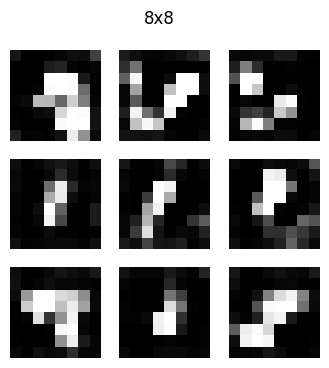


Training 16x16
Epoch 1: G=0.637 D=0.645
Epoch 2: G=0.694 D=0.667


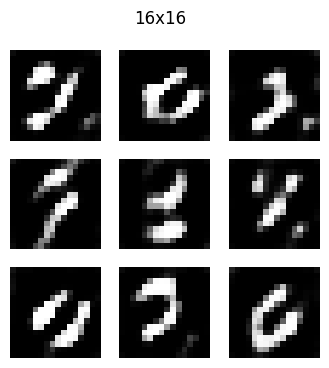


Training 32x32
Epoch 1: G=0.691 D=0.560
Epoch 2: G=0.786 D=0.629


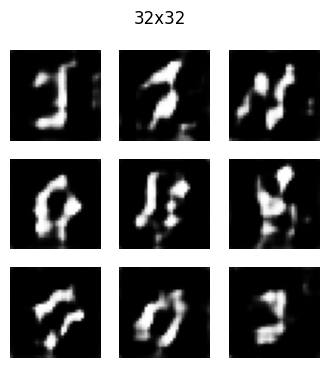


Training 64x64
Epoch 1: G=0.995 D=0.427
Epoch 2: G=1.055 D=0.578


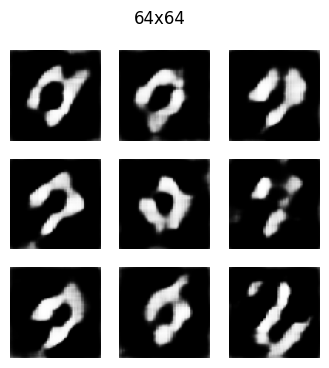

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

LATENT, BATCH, EPOCHS = 100, 64, 2
STAGES = [8, 16, 32, 64]

(x, _), _ = tf.keras.datasets.mnist.load_data()
x = (x.astype('float32') / 127.5 - 1)[..., None]

def G(r):
    m = tf.keras.Sequential([tf.keras.layers.Input((LATENT,)),
                             tf.keras.layers.Dense(4*4*128),
                             tf.keras.layers.Reshape((4,4,128))])
    c, f = 4, 128
    while c < r:
        m.add(tf.keras.layers.UpSampling2D())
        f = max(16, f//2)
        m.add(tf.keras.layers.Conv2D(f, 3, padding='same'))
        m.add(tf.keras.layers.LeakyReLU(0.2))
        c *= 2
    m.add(tf.keras.layers.Conv2D(1, 3, padding='same', activation='tanh'))
    return m

def D(r):
    m = tf.keras.Sequential([tf.keras.layers.Input((r,r,1))])
    f, c = 32, r
    while c > 4:
        m.add(tf.keras.layers.Conv2D(f, 3, padding='same'))
        m.add(tf.keras.layers.LeakyReLU(0.2))
        m.add(tf.keras.layers.AveragePooling2D(2))
        c //= 2
        f = min(256, f*2)
    m.add(tf.keras.layers.Flatten())
    m.add(tf.keras.layers.Dense(1, 'sigmoid'))
    return m

bce = tf.keras.losses.BinaryCrossentropy()

def train_step(G, D, real, g_opt, d_opt):
    z = tf.random.normal([real.shape[0], LATENT])
    with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
        fake = G(z, training=True)
        r_logit, f_logit = D(real, training=True), D(fake, training=True)
        g_loss = bce(tf.ones_like(f_logit), f_logit)
        d_loss = (bce(tf.ones_like(r_logit), r_logit) +
                  bce(tf.zeros_like(f_logit), f_logit)) / 2

    g_grads = g_tape.gradient(g_loss, G.trainable_variables)
    d_grads = d_tape.gradient(d_loss, D.trainable_variables)

    g_opt.apply_gradients(zip(g_grads, G.trainable_variables))
    d_opt.apply_gradients(zip(d_grads, D.trainable_variables))

    return float(g_loss), float(d_loss)

for r in STAGES:
    print(f"\nTraining {r}x{r}")
    G_model, D_model = G(r), D(r)

    # Create new optimizers for each stage
    g_opt = tf.keras.optimizers.Adam(2e-4, 0.5)
    d_opt = tf.keras.optimizers.Adam(2e-4, 0.5)

    ds = tf.data.Dataset.from_tensor_slices(
        tf.image.resize(x, [r, r]).numpy()
    ).shuffle(10000).batch(BATCH)

    for epoch in range(EPOCHS):
        g_losses, d_losses = [], []
        for batch in ds.take(100):
            g_loss, d_loss = train_step(G_model, D_model, batch, g_opt, d_opt)
            g_losses.append(g_loss)
            d_losses.append(d_loss)
        print(f"Epoch {epoch+1}: G={np.mean(g_losses):.3f} D={np.mean(d_losses):.3f}")

    # Generate samples
    samples = (G_model(tf.random.normal([9, LATENT]), training=False).numpy() + 1) / 2
    fig, axes = plt.subplots(3, 3, figsize=(4, 4))
    for img, ax in zip(samples, axes.flat):
        ax.imshow(img[..., 0], cmap='gray')
        ax.axis('off')
    plt.suptitle(f"{r}x{r}")
    plt.show()

# 9) Implement a style transfer algorithm using GANs.

1.   Go to Kaggle and Login your account
2.   Go to Settings and Create New Token under API section
3.   It will download kaggle.json and upload it by running the first cell in this section
4.   It makes the session to download the dataset `pix2pix-dataset`


In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()  # upload kaggle.json (from your Kaggle account)
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d vikramtiwari/pix2pix-dataset
!unzip -q pix2pix-dataset.zip -d /content/


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/vikramtiwari/pix2pix-dataset
License(s): unknown
 99% 2.38G/2.40G [00:30<00:00, 31.3MB/s]
100% 2.40G/2.40G [00:31<00:00, 82.9MB/s]


step 0 d:1.4058 g:54.0396
step 500 d:1.0488 g:19.9565
step 1000 d:0.6137 g:23.4203
step 1500 d:1.0115 g:18.5103
step 2000 d:0.7047 g:21.4294
step 2500 d:0.6995 g:21.1267
step 3000 d:0.7650 g:19.3573
step 3500 d:0.4957 g:20.3042
step 4000 d:0.6230 g:19.9045
step 4500 d:0.6958 g:16.8151


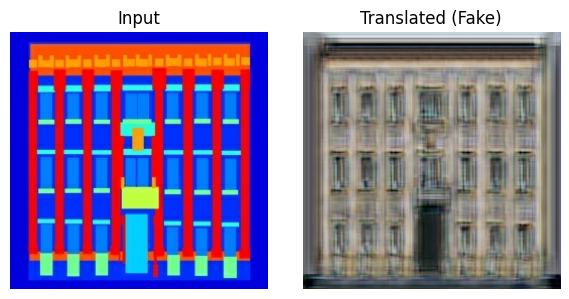

In [4]:
import tensorflow as tf,os,matplotlib.pyplot as plt

IMG,BATCH=256,4
images_dir='/content/facades/facades/train'

def split(p):
    i=tf.image.decode_jpeg(tf.io.read_file(p),3)
    w=tf.shape(i)[1]//2
    a=tf.image.resize(tf.cast(i[:,w:,:],tf.float32)/255.,[IMG,IMG])
    b=tf.image.resize(tf.cast(i[:,:w,:],tf.float32)/255.,[IMG,IMG])
    return a,b

paths=[os.path.join(images_dir,f) for f in os.listdir(images_dir)]

ds=tf.data.Dataset.from_tensor_slices(paths).map(split).shuffle(512).batch(BATCH).prefetch(tf.data.AUTOTUNE)

def G():
    i=tf.keras.Input([IMG,IMG,3])
    x=tf.keras.layers.Conv2D(32,4,2,'same',activation='relu')(i)
    s1=x

    x=tf.keras.layers.Conv2D(64,4,2,'same',activation='relu')(x)
    s2=x

    x=tf.keras.layers.Conv2D(128,4,2,'same',activation='relu')(x)

    x=tf.keras.layers.UpSampling2D(2)(x)
    x=tf.keras.layers.Conv2D(64,3,1,'same',activation='relu')(x)
    x=tf.keras.layers.Concatenate()([x,s2])

    x=tf.keras.layers.UpSampling2D(2)(x)
    x=tf.keras.layers.Conv2D(32,3,1,'same',activation='relu')(x)
    x=tf.keras.layers.Concatenate()([x,s1])

    x=tf.keras.layers.UpSampling2D(2)(x)
    o=tf.keras.layers.Conv2D(3,3,1,'same',activation='tanh')(x)

    return tf.keras.Model(i,o)

def D():
    a=tf.keras.Input([IMG,IMG,3])
    b=tf.keras.Input([IMG,IMG,3])
    x=tf.keras.layers.Concatenate()([a,b])

    x=tf.keras.layers.Conv2D(32,4,2,'same')(x)
    x=tf.keras.layers.LeakyReLU(0.2)(x)

    x=tf.keras.layers.Conv2D(64,4,2,'same')(x)
    x=tf.keras.layers.LeakyReLU(0.2)(x)

    x=tf.keras.layers.Conv2D(128,4,1,'same')(x)
    x=tf.keras.layers.LeakyReLU(0.2)(x)

    o=tf.keras.layers.Conv2D(1,4,1,'same',activation='sigmoid')(x)

    return tf.keras.Model([a,b],o)

gen,disc=G(),D()

bce=tf.keras.losses.BinaryCrossentropy()
mae=tf.keras.losses.MeanAbsoluteError()

gopt=tf.keras.optimizers.Adam(2e-4,0.5)
dopt=tf.keras.optimizers.Adam(2e-4,0.5)

@tf.function
def step(inp,real,lam=100.0):
    with tf.GradientTape() as td:
        fake=gen(inp,training=True)
        ro=disc([inp,real],training=True)
        fo=disc([inp,fake],training=True)
        dl=bce(tf.ones_like(ro),ro)+bce(tf.zeros_like(fo),fo)

    dopt.apply_gradients(zip(td.gradient(dl,disc.trainable_variables),disc.trainable_variables))

    with tf.GradientTape() as tg:
        fake=gen(inp,training=True)
        fo=disc([inp,fake],training=False)
        gl=bce(tf.ones_like(fo),fo)+lam*mae(real,fake)

    gopt.apply_gradients(zip(tg.gradient(gl,gen.trainable_variables),gen.trainable_variables))

    return dl,gl

it=iter(ds.repeat())
# Train longer
for s in range(5000):  # instead of 200
    x, y = next(it)
    dl, gl = step(x, y)
    if s % 500 == 0:
        print(f"step {s} d:{dl.numpy():.4f} g:{gl.numpy():.4f}")
# After training
x, y = next(iter(ds))
f = gen(x, training=False)

# Show only input and translated (fake) image
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.imshow(x[0])
plt.axis('off')
plt.title('Input')

plt.subplot(1, 2, 2)
plt.imshow(f[0])
plt.axis('off')
plt.title('Translated')

plt.tight_layout()
plt.show()





step 0: D=1.5896, G=38.3651
step 200: D=0.0104, G=18.7821
step 400: D=0.0213, G=17.4584
step 600: D=0.0208, G=15.1283
step 800: D=0.0023, G=17.3815


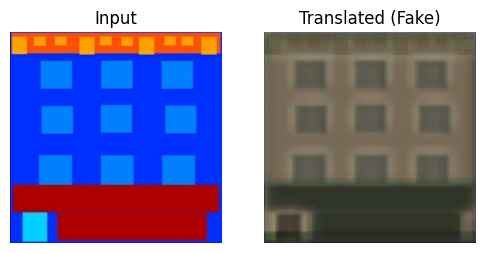

In [5]:
import tensorflow as tf, os, matplotlib.pyplot as plt

IMG, BATCH = 256, 4
images_dir = '/content/facades/facades/train'

def split(p):
    i = tf.image.decode_jpeg(tf.io.read_file(p), 3)
    w = tf.shape(i)[1] // 2
    a = tf.image.resize(tf.cast(i[:, w:, :], tf.float32)/255., [IMG, IMG])
    b = tf.image.resize(tf.cast(i[:, :w, :], tf.float32)/255., [IMG, IMG])
    return a, b

paths = [os.path.join(images_dir, f) for f in os.listdir(images_dir)]

ds = tf.data.Dataset.from_tensor_slices(paths).map(split).shuffle(512).batch(BATCH).prefetch(tf.data.AUTOTUNE)

# ---------------------------
# GENERATOR (unchanged)
# ---------------------------
def G():
    i = tf.keras.Input([IMG, IMG, 3])
    x = tf.keras.layers.Conv2D(32, 4, 2, 'same', activation='relu')(i)
    s1 = x
    x = tf.keras.layers.Conv2D(64, 4, 2, 'same', activation='relu')(x)
    s2 = x
    x = tf.keras.layers.Conv2D(128, 4, 2, 'same', activation='relu')(x)

    x = tf.keras.layers.UpSampling2D(2)(x)
    x = tf.keras.layers.Conv2D(64, 3, 1, 'same', activation='relu')(x)
    x = tf.keras.layers.Concatenate()([x, s2])

    x = tf.keras.layers.UpSampling2D(2)(x)
    x = tf.keras.layers.Conv2D(32, 3, 1, 'same', activation='relu')(x)
    x = tf.keras.layers.Concatenate()([x, s1])

    x = tf.keras.layers.UpSampling2D(2)(x)
    o = tf.keras.layers.Conv2D(3, 3, 1, 'same', activation='tanh')(x)
    return tf.keras.Model(i, o)

# ---------------------------
# PATCHGAN DISCRIMINATOR
# ---------------------------
def D():
    inp = tf.keras.Input([IMG, IMG, 3])
    tar = tf.keras.Input([IMG, IMG, 3])

    x = tf.keras.layers.Concatenate()([inp, tar])

    # PatchGAN: progressively downsample
    x = tf.keras.layers.Conv2D(64, 4, 2, 'same')(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(128, 4, 2, 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(256, 4, 2, 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(512, 4, 1, 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    # PatchGAN output — NOT a single scalar, but an N×N map
    o = tf.keras.layers.Conv2D(1, 4, 1, 'same', activation='sigmoid')(x)

    return tf.keras.Model([inp, tar], o)

# ---------------------------
# LOSSES & TRAINING
# ---------------------------
gen, disc = G(), D()
bce = tf.keras.losses.BinaryCrossentropy()
mae = tf.keras.losses.MeanAbsoluteError()
gopt = tf.keras.optimizers.Adam(2e-4, 0.5)
dopt = tf.keras.optimizers.Adam(2e-4, 0.5)

@tf.function
def step(inp, real, lam=100.0):
    with tf.GradientTape() as td:
        fake = gen(inp, training=True)
        ro = disc([inp, real], training=True)
        fo = disc([inp, fake], training=True)
        dl = bce(tf.ones_like(ro), ro) + bce(tf.zeros_like(fo), fo)
    dopt.apply_gradients(zip(td.gradient(dl, disc.trainable_variables), disc.trainable_variables))

    with tf.GradientTape() as tg:
        fake = gen(inp, training=True)
        fo = disc([inp, fake], training=False)
        gl = bce(tf.ones_like(fo), fo) + lam * mae(real, fake)
    gopt.apply_gradients(zip(tg.gradient(gl, gen.trainable_variables), gen.trainable_variables))
    return dl, gl

# ---------------------------
# TRAIN LOOP
# ---------------------------
it = iter(ds.repeat())
for s in range(1000):  # shorter demo training
    x, y = next(it)
    dl, gl = step(x, y)
    if s % 200 == 0:
        print(f"step {s}: D={dl.numpy():.4f}, G={gl.numpy():.4f}")

# ---------------------------
# TEST AND SHOW ONLY INPUT + FAKE
# ---------------------------
x, y = next(iter(ds))
f = gen(x, training=False)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(x[0])
plt.title('Input')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(f[0])
plt.title('Translated (Fake)')
plt.axis('off')
plt.show()


# 10) Implement a basic transformer model using PyTorch or TensorFlow and train it on a text dataset like WikiText-2 for language modeling.

In [ ]:

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

texts = [
    "machine learning is fascinating and powerful",
    "deep learning is a subset of machine learning",
    "neural networks can learn complex patterns",
    "transformers are great for natural language processing",
    "language models can generate realistic text"
]

corpus = " ".join(texts)
tokens = corpus.lower().split()
vocab = sorted(set(tokens))
word_index = {w: i + 1 for i, w in enumerate(vocab)}
index_word = {i + 1: w for i, w in enumerate(vocab)}
vocab_size = len(vocab) + 1

input_sequences = []
target_sequences = []
for i in range(1, len(tokens)):
    input_sequences.append([word_index[w] for w in tokens[:i]])
    target_sequences.append([word_index[w] for w in tokens[1:i+1]])

max_len = max(len(s) for s in input_sequences)
X = tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=max_len, padding="pre")
y = tf.keras.preprocessing.sequence.pad_sequences(target_sequences, maxlen=max_len, padding="pre")

class PositionalEmbedding(layers.Layer):
    def __init__(self, vocab_size, max_len, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(vocab_size, embed_dim)
        self.pos_emb = layers.Embedding(max_len, embed_dim)

    def call(self, x):
        positions = tf.range(tf.shape(x)[-1])
        return self.token_emb(x) + self.pos_emb(positions)

def transformer_block(x, embed_dim, num_heads, ff_dim, dropout=0.1):
    attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    attn = layers.Dropout(dropout)(attn)
    x = layers.LayerNormalization(epsilon=1e-6)(x + attn)
    ffn = layers.Dense(ff_dim, activation="relu")(x)
    ffn = layers.Dense(embed_dim)(ffn)
    return layers.LayerNormalization(epsilon=1e-6)(x + ffn)

def build_transformer_lm(vocab_size, seq_length, embed_dim=64, num_heads=2, ff_dim=128, num_layers=2):
    inputs = layers.Input(shape=(seq_length,))
    x = PositionalEmbedding(vocab_size, seq_length, embed_dim)(inputs)
    for _ in range(num_layers):
        x = transformer_block(x, embed_dim, num_heads, ff_dim)
    outputs = layers.Dense(vocab_size, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)

model = build_transformer_lm(vocab_size, X.shape[1])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()
model.fit(X, y, epochs=100, batch_size=16, verbose=1)

def generate_text(seed_text, num_words=10):
    for _ in range(num_words):
        token_list = [word_index.get(w, 0) for w in seed_text.split()]
        token_list = tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=X.shape[1], padding="pre")
        preds = model.predict(token_list, verbose=0)
        predicted = int(np.argmax(preds[0, -1, :]))
        seed_text += " " + index_word.get(predicted, "")
    return seed_text

print("\n--- Text Generation ---")
print(generate_text("machine learning is", num_words=25))


# 11) Fine-tune a pre-trained GPT model on a specific task such as sentiment analysis using a dataset like IMDB reviews.

In [ ]:

import tensorflow as tf
from transformers import GPT2Tokenizer, TFGPT2ForSequenceClassification
texts = [
 "I love this movie, it was fantastic!",
 "Absolutely wonderful experience, would recommend!",
 "Terrible movie, I hated every moment.",
 "Worst film ever, waste of time.",
 "The acting was brilliant and touching.",
 "Awful plot and bad direction.",
 "A great story and strong performances.",
 "It was boring and too long."
]
labels = [1,1,0,0,1,0,1,0]
trn_texts, tst_texts = texts[:6], texts[6:]
trn_labels, tst_labels = labels[:6], labels[6:]
mname = "distilgpt2"
tok = GPT2Tokenizer.from_pretrained(mname)
tok.pad_token = tok.eos_token
def enc(txts):
    return tok(txts, truncation=True, padding=True, max_length=64, return_tensors="tf")
trn_enc = enc(trn_texts)
tst_enc = enc(tst_texts)
trn_ds = tf.data.Dataset.from_tensor_slices((dict(trn_enc), trn_labels)).shuffle(6).batch(2)
tst_ds = tf.data.Dataset.from_tensor_slices((dict(tst_enc), tst_labels)).batch(2)
model = TFGPT2ForSequenceClassification.from_pretrained(mname, num_labels=2, from_pt=True)
model.config.pad_token_id = tok.eos_token_id
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer="adam", loss=loss, metrics=["accuracy"])
model.fit(trn_ds, validation_data=tst_ds, epochs=3)
print("Eval:", model.evaluate(tst_ds))
def predict(text):
    e = tok(text, return_tensors="tf", truncation=True, padding=True, max_length=64)
    logits = model(e).logits
    p = int(tf.argmax(logits, axis=-1).numpy()[0])
    return "Positive 😀" if p==1 else "Negative 😠"
for ex in ["The movie was absolutely amazing!","It was dull and disappointing.","The plot was okay, but the acting was weak."]:
    print(ex,"->",predict(ex))


# 12) Utilize the OpenAI API to build a question-answering application powered by GPT-3, allowing users to input questions and receive relevant answers.
# NOT FINALIZED YET (NOT PLAYGROUND VERSION)
1.   Go to OpenRouter and Login your account
2.   Go to Settings and Create API key under API keys section
3.   Copy the key and Make a secret key under the name "OPENROUTER-API-KEY" and value is copied key value.
4.   Enable the Notebook Access.


 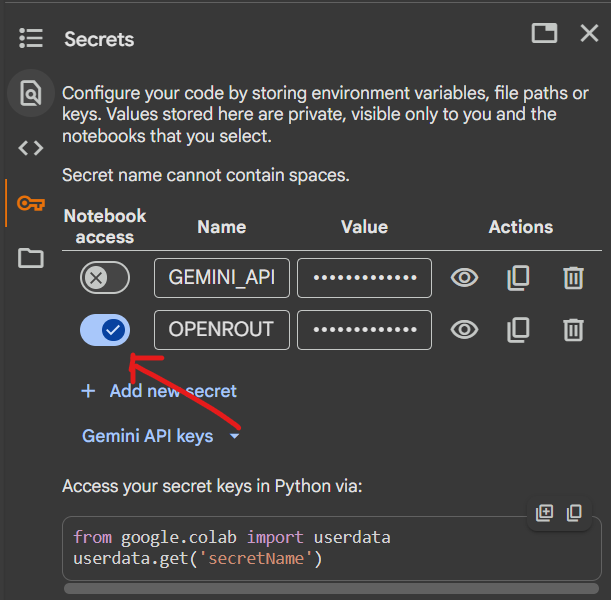

In [7]:
from google.colab import userdata


In [10]:
import gradio as gr
import requests
import json
from google.colab import userdata

OPENROUTER_API_KEY = userdata.get('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')


SecretNotFoundError: Secret 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 does not exist.

In [6]:
import gradio as gr
import requests
import json
from google.colab import userdata



def chat_with_model(user_input, chat_history):
    # Prepare messages for API
    messages = []
    for role, content in chat_history:
        messages.append({"role": role, "content": content})
    messages.append({"role": "user", "content": user_input})

    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {OPENROUTER_API_KEY}",
            "Content-Type": "application/json"
        },
        data=json.dumps({
            "model": "openai/gpt-oss-20b:free",
            "messages": messages
        })
    )

    if response.status_code == 200:
        data = response.json()
        reply = data['choices'][0]['message']['content']
    else:
        reply = f"Error {response.status_code}: {response.content}"

    chat_history.append(("user", user_input))
    chat_history.append(("assistant", reply))

    return chat_history, chat_history

with gr.Blocks() as demo:
    chat = gr.Chatbot()
    msg = gr.Textbox(placeholder="Ask a question...")
    state = gr.State([])  # stores the conversation as list of tuples (role, content)

    msg.submit(chat_with_model, inputs=[msg, state], outputs=[chat, state])

demo.launch()

/tmp/ipython-input-3523262061.py:39: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chat = gr.Chatbot()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c60f313aed3343dd09.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


OPENROUTER_API_KEY = userdata.get('OPENROUTER_API_KEY')  # or set your key here as a string